In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np

In [2]:
from collections import Counter
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

In [3]:
df = pickle.load(open('dataframe.pickle', 'rb'))
print(df.dtypes)
df.head()

issuercountrycode                object
txvariantcode                    object
bin                             float64
amount                          float64
currencycode                     object
shoppercountrycode               object
shopperinteraction               object
cardverificationcodesupplied     object
cvcresponsecode                   int64
creationdate                     object
accountcode                      object
mail_id                           int64
ip_id                             int64
card_id                           int64
label                             int64
creationdate_timestamp          float64
dtype: object


,issuercountrycode,txvariantcode,bin,amount,currencycode,shoppercountrycode,shopperinteraction,cardverificationcodesupplied,cvcresponsecode,creationdate,accountcode,mail_id,ip_id,card_id,label,creationdate_timestamp
196377,GB,visagold,494120.0,5227.0,GBP,GB,ContAuth,False,0,2015-10-1,UKAccount,273151,250291,216279,0,1.443726e+09
195925,GB,visadebit,492181.0,6895.0,GBP,GB,Ecommerce,NaN,1,2015-10-1,UKAccount,194157,13886,19361,0,1.443708e+09
195926,GB,visadebit,465858.0,8695.0,GBP,GB,Ecommerce,NaN,1,2015-10-1,UKAccount,230463,52387,106890,0,1.443708e+09
195927,GB,visadebit,476367.0,21700.0,GBP,GB,Ecommerce,True,1,2015-10-1,UKAccount,145581,43039,177365,0,1.443708e+09
195928,HK,visaplatinum,455728.0,9995.0,GBP,HK,Ecommerce,True,1,2015-10-1,UKAccount,90133,25944,175345,0,1.443708e+09


In [4]:
# TODO: to verify, does this dataframe takes into account Refused transactions?
# How many entries in total ?
df.shape[0]

236698

In [5]:
# How many of those are fraudolent and how many are safe ?
s = df.label.value_counts()
print s
print s[1]/float(s[0])

0    236353
1       345
Name: label, dtype: int64
0.0014596810702635465


In [6]:
# TODO clean and filter only the interesting features, this is just an example:
df_interesting = df[['label','ip_id','issuercountrycode']]
df_interesting.loc[:,('issuercountrycode')] = df_interesting['issuercountrycode'].fillna('??') # We add a custom value for unknown codes
# Convert categorical variable into numerical classes
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(df_interesting['issuercountrycode'])
df_interesting.loc[:,('issuercountrycode')] = le.transform(df_interesting['issuercountrycode'])
df_interesting.head()

/home/luigi/Desktop/my_lab/UNI/SaP_Master/UT/Q4/CDA/penv/local/lib/python2.7/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,label,ip_id,issuercountrycode
196377,0,250291,41
195925,0,13886,41
195926,0,52387,41
195927,0,43039,41
195928,0,25944,45


In [7]:
# Creating training and test sets
training_features, test_features, \
training_target, test_target, = train_test_split(df_interesting.drop(['label'], axis=1),
                                               df_interesting['label'],
                                               test_size = .1,
                                               random_state=12)


In [8]:
# SMOTE analysis (note, this is done after sampling)
sm = SMOTE(random_state=12)
x_res, y_res = sm.fit_sample(training_features, training_target)
print training_target.value_counts()
print np.bincount(y_res)


0    212725
1       303
Name: label, dtype: int64
[212725 212725]


In [9]:
from sklearn import tree
dt = tree.DecisionTreeClassifier(max_depth=3)
dt = dt.fit(x_res, y_res)

In [10]:
dt.score(test_features,test_target)

0.8516265314744402

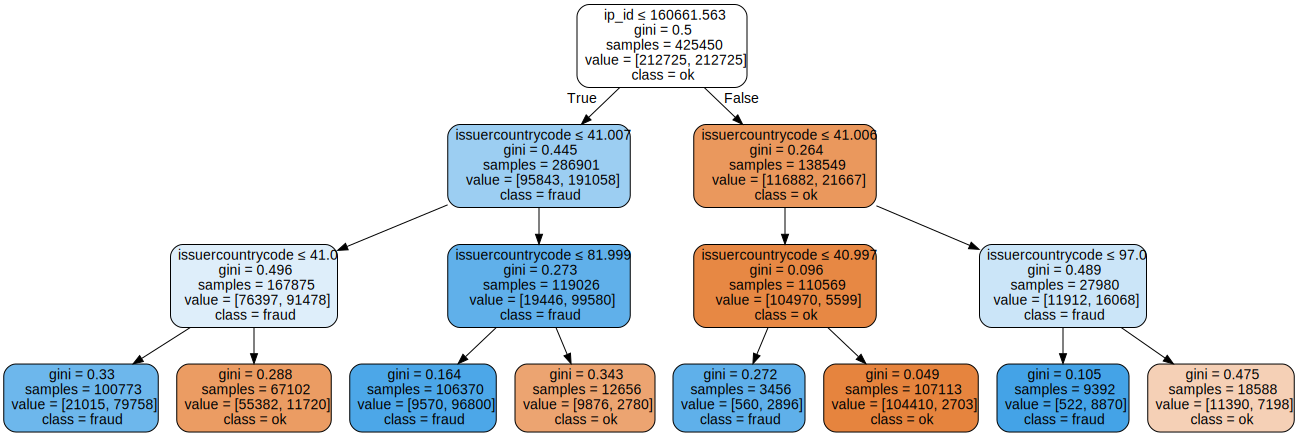

In [17]:
import graphviz
dot_data = tree.export_graphviz(dt, out_file=None,
                               feature_names=list(df_interesting.columns.values[1:]),
                               class_names=['ok','fraud'],filled=True, rounded=True,  
                               special_characters=True
                              ) 
graph = graphviz.Source(dot_data) 
graph